<a href="https://colab.research.google.com/github/yacanom/MINE-4210_202320_ANALISIS_CON_DEEP_LEARNING/blob/main/Laboratorio%204/MINE4210_ADL2023_LAB4_Pr%C3%A1ctica_2_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)







# **Laboratorio 4. 2**

## **Objetivos**
*   Analizar la Arquitectura de la red GAN.
*   Generar imágenes a partir de una red GAN.


## **Problema**
- Para este problema, vamos a utilizar un conjunto de imágenes llamado [Fashion MNIST](https://www.tensorflow.org/datasets/catalog/fashion_mnist), el cual consta de 10 productos catalogados por imagenes, cada imagen viene de tamaño 28 x 28 y en escala de grises.

### 0. Importación de paquetes

Para este ejercicio, utilizaremos las siguientes librerías.

In [ ]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

from keras.models import Model
from keras.losses import binary_crossentropy
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from keras import backend as K
from keras import applications
from tensorflow.keras.utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.14.0


### 1. Entendimiento del Negocio

El negocio nos ha bridado el siguiente diccionario de datos:

Este Dataset consta de 60,000 28x28 imágenes a escala de grises de 10 categorias de ropa, junto a un conjunto de 10,000 imágenes de test.

Las clases son:

|Etiqueta|Descripción|
|---|---|
|0|T-shirt/top|
|1|Trouser|
|2|Pullover|
|3|Dress|
|4|Coat|
|5|Sandal|
|6|Shirt|
|7|Sneaker|
|8|Bag|
|9|Ankle boot|

### 2. Entendimeinto de los Datos

Realizamos la carga del código, para validar si la carga de los datos es correcta.

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 1s 0us/step


Visualizamos al azar una imagen, para poder verificar que se haya realizado la carga.

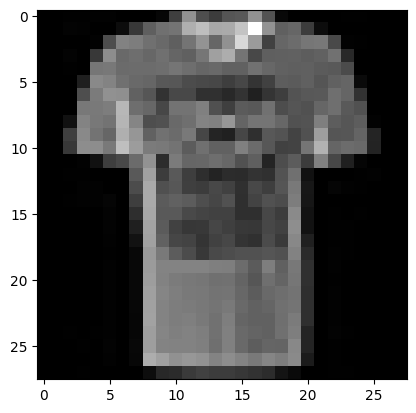

In [ ]:
# select any random index from 1 to 60,000
i = random.randint(1,X_train.shape[0])
plt.imshow(X_train[i] , cmap = 'gray')

In [ ]:
label = y_train[i]
label

0

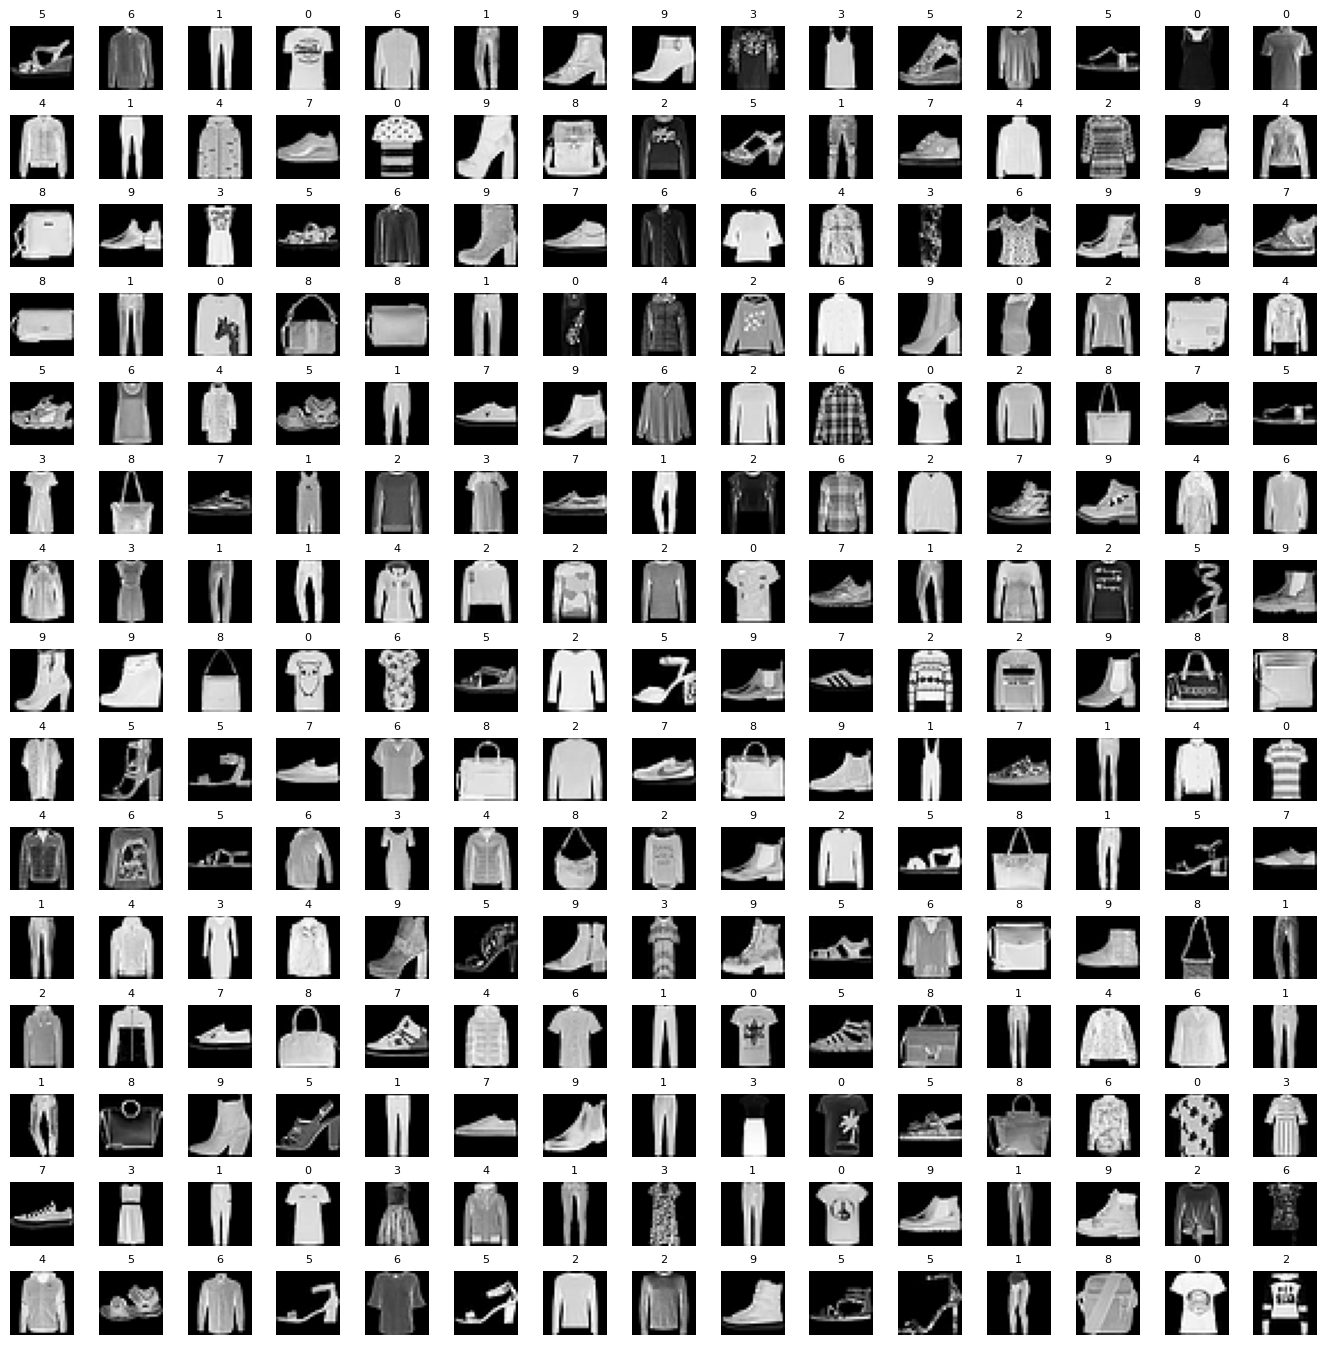

In [ ]:
W_grid = 15
L_grid = 15

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))
axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array
n_training = len(X_train) # get the length of the training dataset

# Select a random number from 0 to n_training
for i in np.arange(0, W_grid * L_grid):
    index = np.random.randint(0, n_training)
    axes[i].imshow( X_train[index], cmap='gray')
    axes[i].set_title(y_train[index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

## 2. Preparación de datos

Para entrenar el modelo, realizamos una normalización de los datos para que se encuentren entre el rango [0,1]. Esto no afectará la construcción de la imagen.

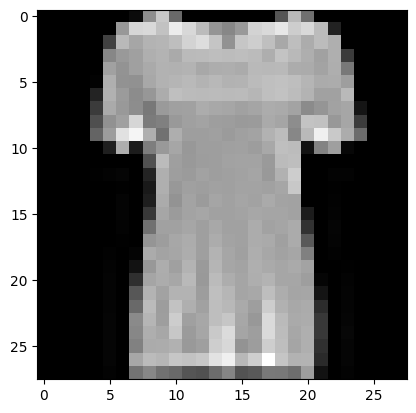

In [ ]:
plt.imshow(X_train[10].reshape(28, 28), cmap="gray")

## 3.  GAN

Primero, necesitamos construir el generador y el discriminador. El generador es similar al decodificador de un autoencoder, y el discriminador es un clasificador binario normal: toma una imagen como entrada y termina con una capa Densa que contiene una única unidad y utiliza la función de activación sigmoide.

Para la segunda fase de cada iteración de entrenamiento, también necesitamos el modelo GAN completo que contiene el generador seguido del discriminador:

In [ ]:
codings_size = 30

Dense = tf.keras.layers.Dense
generator = tf.keras.Sequential([
    Dense(200, activation="relu", kernel_initializer="he_normal"),
    Dense(300, activation="relu", kernel_initializer="he_normal"),
    Dense(28 * 28, activation="sigmoid"),
    tf.keras.layers.Reshape([28, 28])
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    Dense(300, activation="relu", kernel_initializer="he_normal"),
    Dense(200, activation="relu", kernel_initializer="he_normal"),
    Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])

A continuación, tenemos que compilar estos modelos. Como el discriminador es un clasificador binario, podemos utiliza binary_crossentropy. El modelo gan también es un clasificador binario, por lo que también puede utilizar binary_crossentropy. Sin embargo, el generador sólo se entrenará a través del modelo gan, por lo que no necesitamos compilarlo en absoluto. Es importante destacar que el discriminador no debe ser entrenado durante la segunda fase, por lo que lo hacemos no entrenable antes de compilar el modelo gan:

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

Dado que el bucle de entrenamiento es inusual, no podemos utilizar el método fit() normal. En su lugar, escribiremos función para realizar el entrenamiento. Para ello, primero tenemos que crear un conjunto de datos para iterar a través de las imágenes:

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)

train_gan(gan, dataset, batch_size, codings_size, n_epochs=50)

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


Después del entrenamiento, podemos muestrear aleatoriamente algunas codificaciones de una distribución gaussiana, y alimentarlas al generador para producir nuevas imágenes:

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

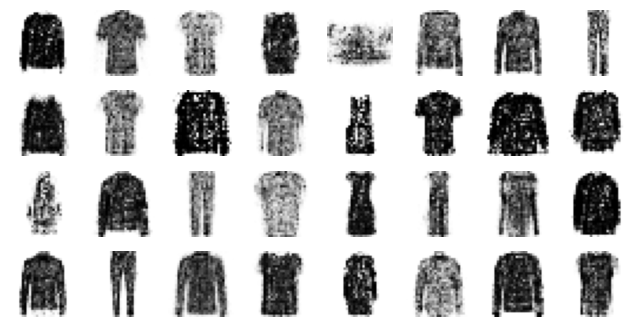

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)